In [1]:
from fastai.vision.all import *

# Chapter 5: Image Classification

# Data

In [2]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/storage/data/oxford-iiit-pet/images'),Path('/storage/data/oxford-iiit-pet/annotations')]

The annotations are information about the pet location, so won't be needed for the classification task.

In [3]:
(path/'images').ls()

(#7393) [Path('/storage/data/oxford-iiit-pet/images/american_bulldog_146.jpg'),Path('/storage/data/oxford-iiit-pet/images/japanese_chin_12.jpg'),Path('/storage/data/oxford-iiit-pet/images/Sphynx_247.jpg'),Path('/storage/data/oxford-iiit-pet/images/beagle_158.jpg'),Path('/storage/data/oxford-iiit-pet/images/beagle_76.jpg'),Path('/storage/data/oxford-iiit-pet/images/shiba_inu_207.jpg'),Path('/storage/data/oxford-iiit-pet/images/Siamese_56.jpg'),Path('/storage/data/oxford-iiit-pet/images/keeshond_194.jpg'),Path('/storage/data/oxford-iiit-pet/images/miniature_pinscher_89.jpg'),Path('/storage/data/oxford-iiit-pet/images/leonberger_42.jpg')...]

It seems that the pet breed is the filename except for the part after the last underscore.

##### Extracting the class from the filename

In [4]:
fname = (path/'images').ls()[0]
fname

Path('/storage/data/oxford-iiit-pet/images/american_bulldog_146.jpg')

Ugly but quick solution:

In [5]:
'_'.join(fname.name.split('_')[:-1])

'american_bulldog'

In [6]:
match = re.match(r"""(.+)_\d+.jpg$""", fname.name)
match.group(1)

'american_bulldog'

### DataBlock

In [7]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=.75))
dls = pets.dataloaders(path/'images')

The min_scale parameter from above enables RandomResizeCrop during batch transformations, while item_tfms Resize chooses a large (460px), random square.

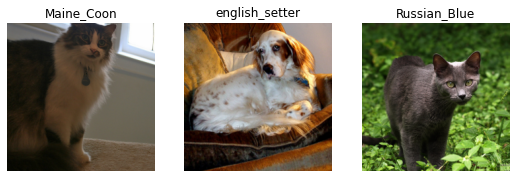

In [8]:
dls.show_batch(nrows=1, ncols=3)

In [9]:
pets.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/oxford-iiit-pet/images/shiba_inu_98.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x374
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /storage/data/oxford-iiit-pet/images/shiba_inu_98.jpg
    applying partial gives
      shiba_inu
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(33)

Final sample: (PILImage mode=RGB size=500x374, TensorCategory(33))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch:

# First simple model

In [10]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.529588,0.330378,0.104195,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.502321,0.306722,0.093369,00:32
1,0.319219,0.239773,0.077131,00:31


The implicitely chosen loss-function is Cross-Entropy Loss.

# Cross entropy loss (multiple classes)

In [11]:
x,y = dls.one_batch()
y

TensorCategory([32, 17,  7, 17,  6, 20, 22,  1, 29, 12,  9,  3, 14, 31, 19, 27, 30, 22,
         4, 35,  9, 26, 30, 26, 14, 20, 16,  9, 26, 23, 22, 11, 20, 34, 35, 13,
        26, 30, 28,  0, 15, 32, 15, 32,  9, 20, 31, 19,  7, 32, 35, 14, 13, 12,
         6, 32, 18,  5, 36, 19, 16, 34, 33, 17], device='cuda:0')

A batch can be passed to learn.get_preds to get the output activations:

In [12]:
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.1958e-09, 9.5874e-09, 1.3488e-09, 5.7941e-09, 3.5707e-09, 4.0955e-09,
        2.7714e-08, 9.6269e-09, 9.5407e-10, 1.7018e-08, 3.3673e-09, 2.5053e-07,
        1.7688e-10, 1.4872e-07, 1.0257e-09, 1.0111e-09, 1.1221e-09, 3.1186e-08,
        4.5819e-07, 2.8307e-08, 2.0884e-09, 8.6384e-10, 1.2184e-07, 2.7198e-09,
        1.5311e-06, 4.0776e-08, 1.9865e-08, 6.4948e-07, 1.1414e-08, 2.1979e-09,
        5.0316e-10, 4.3020e-08, 9.9999e-01, 5.4132e-09, 6.3864e-08, 3.4169e-06,
        2.2065e-08])

Those are the 37 probabilities associated with each class, hence they should add up to 1.

In [13]:
preds[0].sum()

tensor(1.0000)

# Interpretation

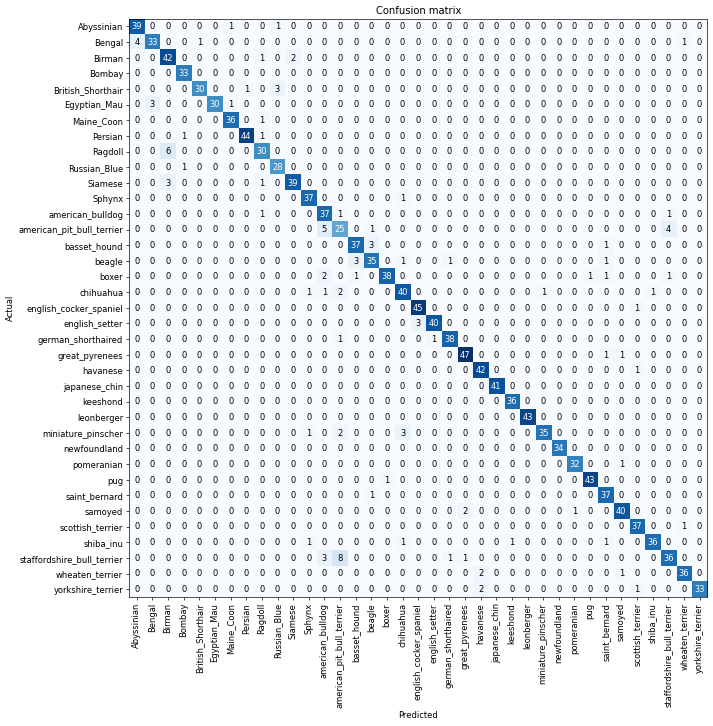

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [15]:
interp.most_confused(min_val=5)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 8),
 ('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'american_bulldog', 5)]

# Improving the model

## Learning rate

Start with a really small learning rate, process one batch and record the loss. Increase the learning rate by a bit and repeat until the loss gets significantly worse.

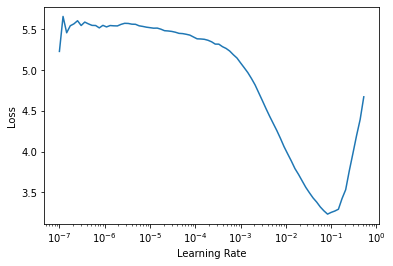

In [16]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In [17]:
lr_min, lr_steep

(0.00831763744354248, 0.007585775572806597)

3e-3 seems to be good, lets try that:

In [18]:
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.304353,0.349969,0.113667,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.534275,0.401331,0.123816,00:32
1,0.338600,0.241482,0.077808,00:32


In [19]:
??learn.fine_tune

In [20]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Train the final layer for 3 epochs, pre-trained layers are frozen by default.

In [21]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.127735,0.347400,0.110961,00:26
1,0.544430,0.260779,0.082544,00:26
2,0.325705,0.248180,0.081867,00:26


For fine-tuning the pretrained parts, a new learning rate should be used because essentially a different model is trained.

SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=9.12010818865383e-07)

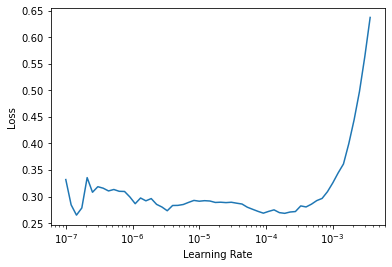

In [22]:
learn.unfreeze()
learn.lr_find()

In [23]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.272049,0.238629,0.079838,00:32
1,0.249208,0.230847,0.076455,00:32
2,0.232591,0.219117,0.072395,00:32
3,0.204506,0.219741,0.069012,00:32
4,0.177266,0.221117,0.070365,00:32
5,0.186055,0.219004,0.074425,00:33


## Discriminative learning

Basic idea: During finetuning, train earlier layers with a smaller learning rate than later ones.

In [24]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.137975,0.358925,0.115020,00:28
1,0.523352,0.279124,0.085927,00:28
2,0.310562,0.257376,0.079161,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.273627,0.243561,0.077808,00:33
1,0.250501,0.244312,0.075778,00:33
2,0.229690,0.234126,0.072395,00:33
3,0.203403,0.232410,0.071719,00:33
4,0.182934,0.227480,0.073072,00:33
5,0.169756,0.227575,0.071042,00:33
6,0.173994,0.226745,0.071042,00:34
7,0.151141,0.226681,0.071719,00:34


## Try: MixedPrecision

In [25]:
from fastai.callback.fp16 import *

In [26]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.434144,0.276291,0.092693,00:41
1,0.612548,0.253199,0.083221,00:39
2,0.451625,0.224708,0.079838,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.283372,0.256817,0.078484,00:51
1,0.332664,0.408054,0.119080,00:50
2,0.243773,0.276720,0.076455,00:50
3,0.163070,0.238514,0.062246,00:50
4,0.082293,0.192192,0.054127,00:50
5,0.056443,0.183065,0.051421,00:51
